# CLIMATE 405: Machine Learning for Earth and Environmental Sciences; FALL 2024
## Mohammed Ombadi (ombadi@umich.edu)

# Lecture 10 (Wednesday, 10/02/2024)
# Topics covered in this lecture:
- An example of applying Multilayer Perceptron (MLP) for rainfall-runoff modeling.
- _Note: Review PowerPoint slides for lecture 10 (Gradient Descent, Backpropagation, Stochastic Gradient Descent, Architechture of a Neural Network, Activation Functions_ 

## Import libraries

In [1]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import warnings

from scipy.integrate import odeint
from IPython.display import Image
from statistics import mode
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
import statsmodels.api as sm
import pingouin as pg

# Suppress warnings
warnings.filterwarnings('ignore')

# Set number of decimals for np print options
np.set_printoptions(precision=3)

# Set the current working directory
os.chdir(sys.path[0])

## <center> Hsu et al. (1995) Study: MLP for Rainfall-Runoff Modelling </center>

This study is the earliest example of applying Multilayer Perceptron (MLP) for rainfall-runoff modelling. The study can be found [here]( https://doi.org/10.1029/95WR01955)

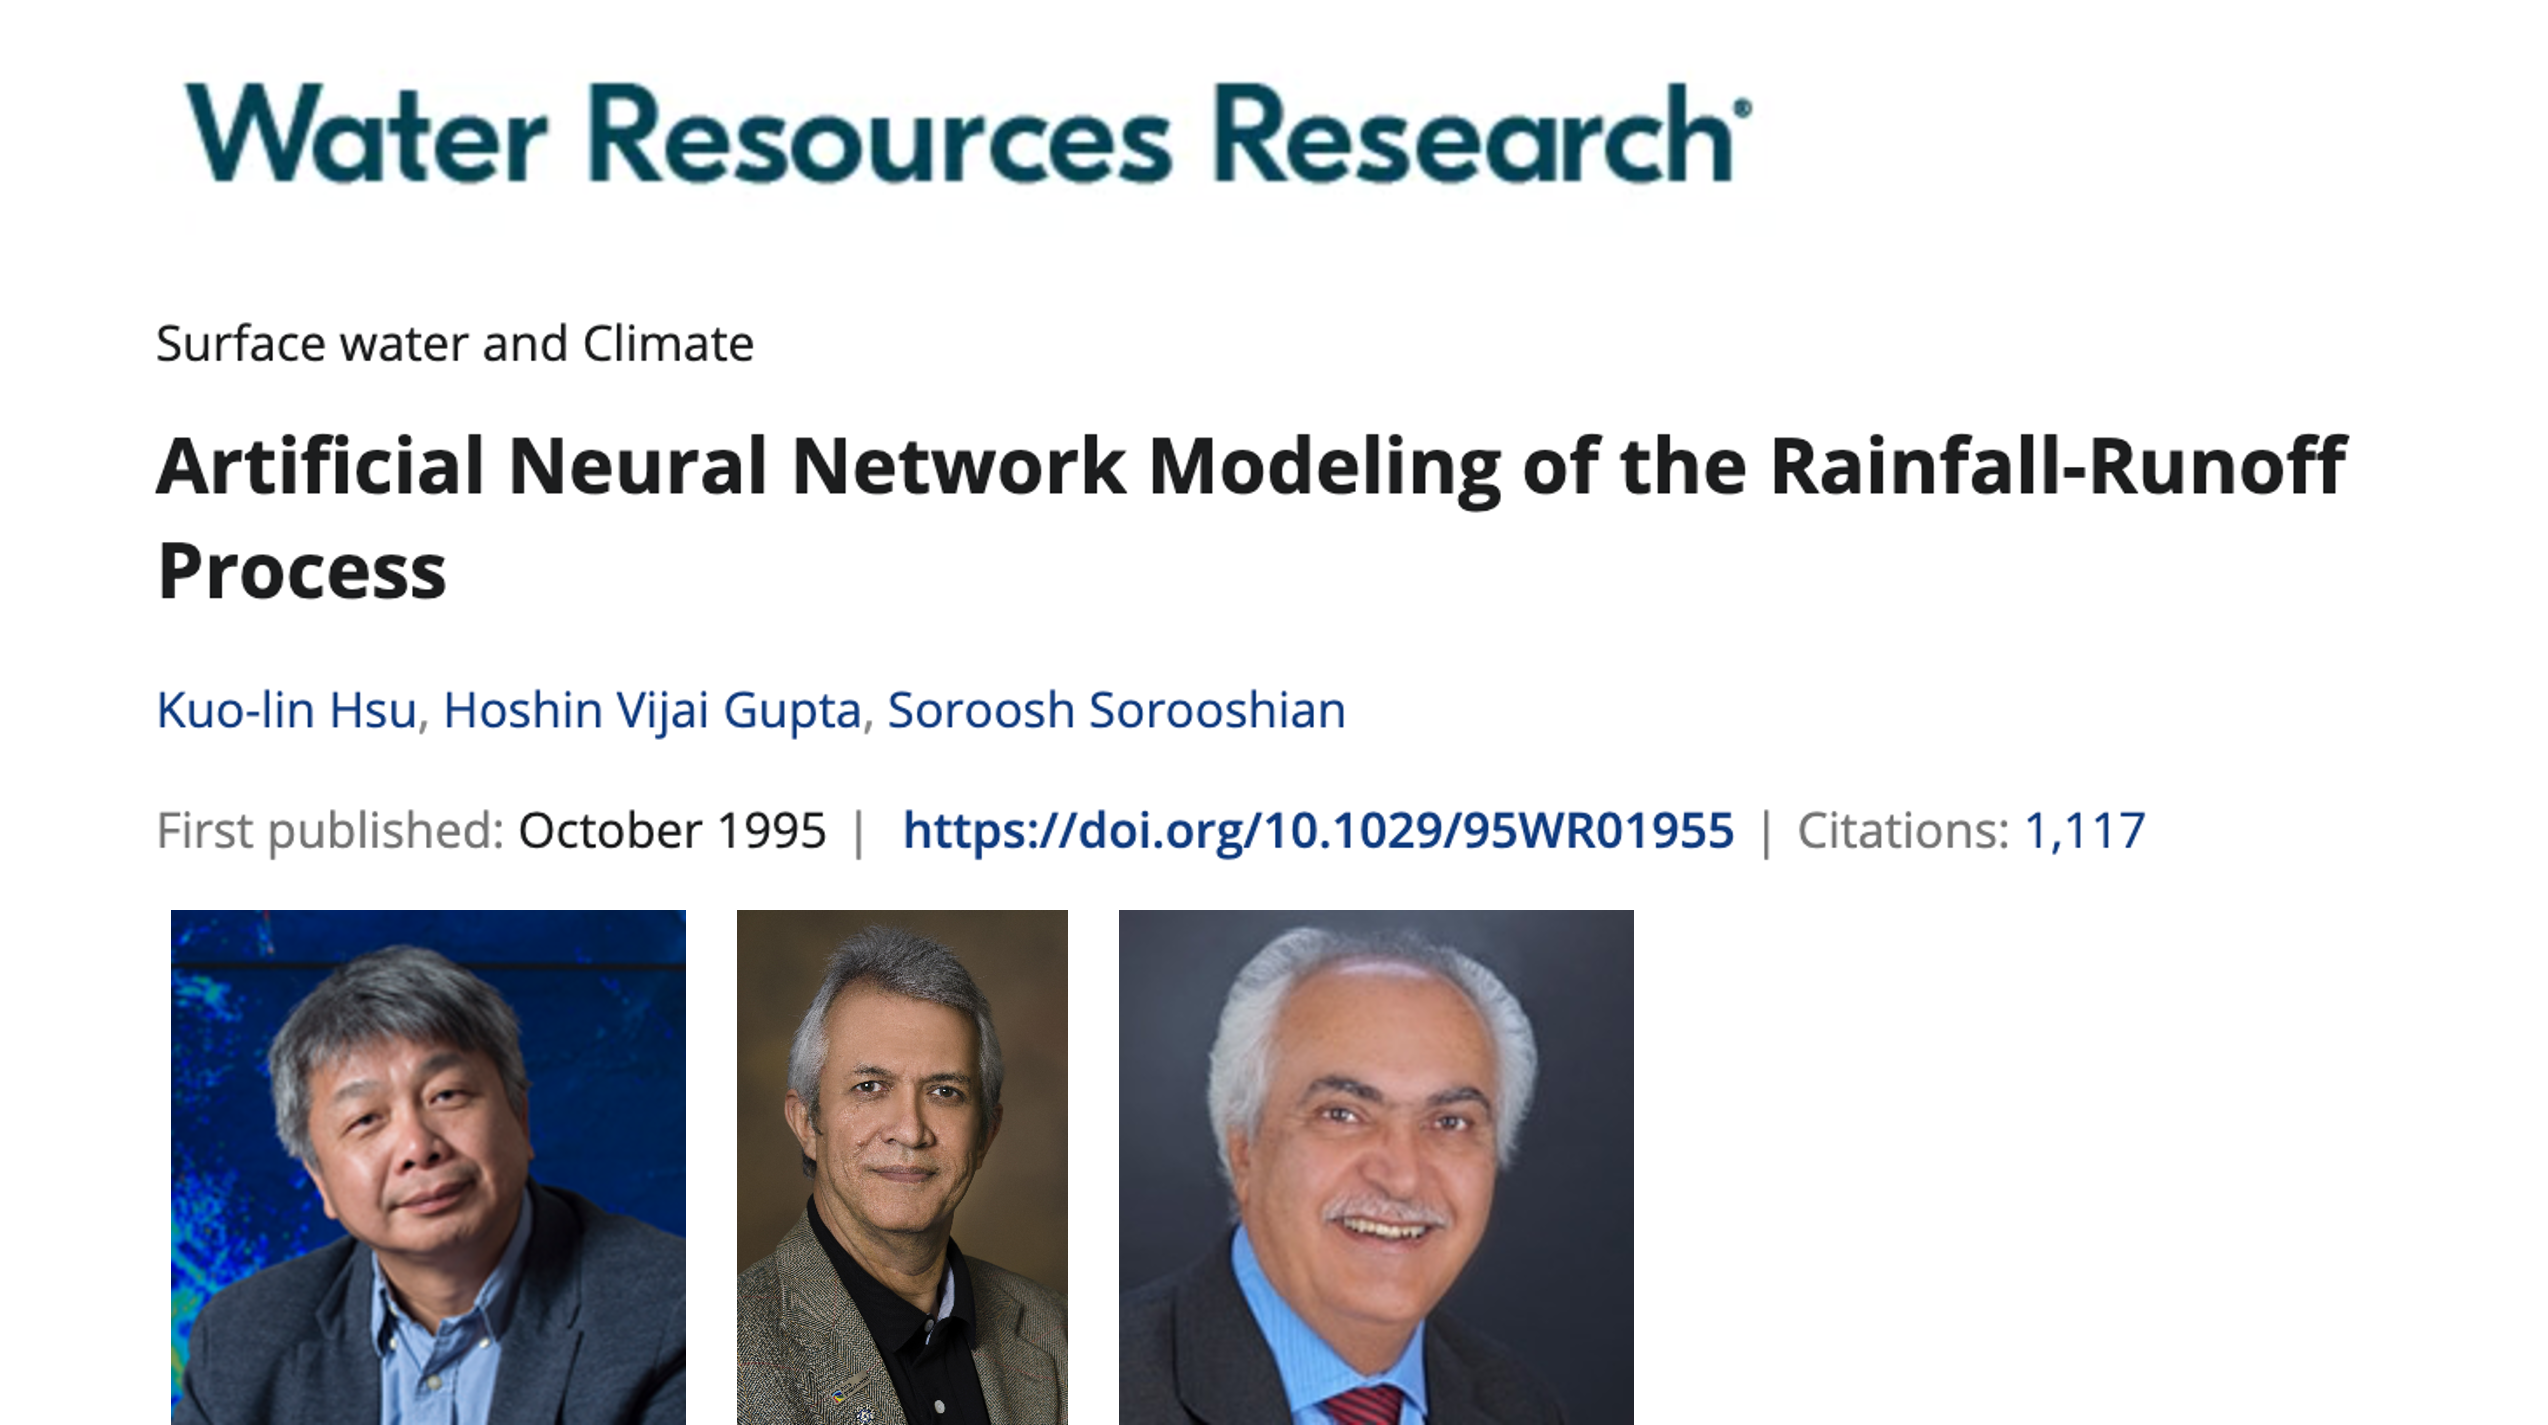

In [2]:
display(Image(filename = 'Hsu et al_WRR 1995.png', width= 600, height= 300))

<span style="font-size: 24px;"> Objectives: <span>
- The objective of this study is to use a multilayer perceptron (MLP) to predict (simulate) runoff using rainfall data as an input. 
- Compare the performance of the MLP model to an autoregressive moving average with exogenous variables (ARMAX)
- Compre the performance to a physics-based conceptual model; The Sacramento Soil Moisture Accounting Model (SAC-SMA)

A diagram desribing the SAC-SMA model:

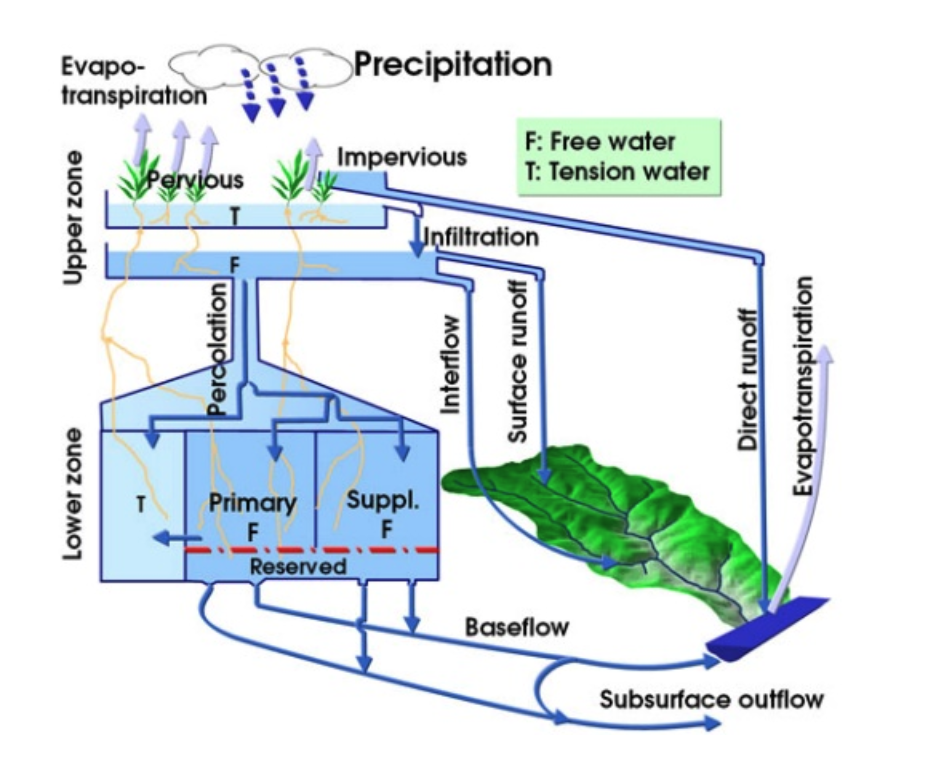

In [3]:
display(Image(filename = 'SAC-SMA.png', width= 600, height= 300))

<span style="font-size: 24px;"> Case Study: <span>

- The Leaf River Basin, near Collins in Mississipi (size = 1949 km2)
- Calibration data: 1983 water year (10/01/1982 - 09/30/1983)
- Validation data: water years 1984 - 1988

<span style="font-size: 24px;"> The General Architecture of the MLP model: <span>

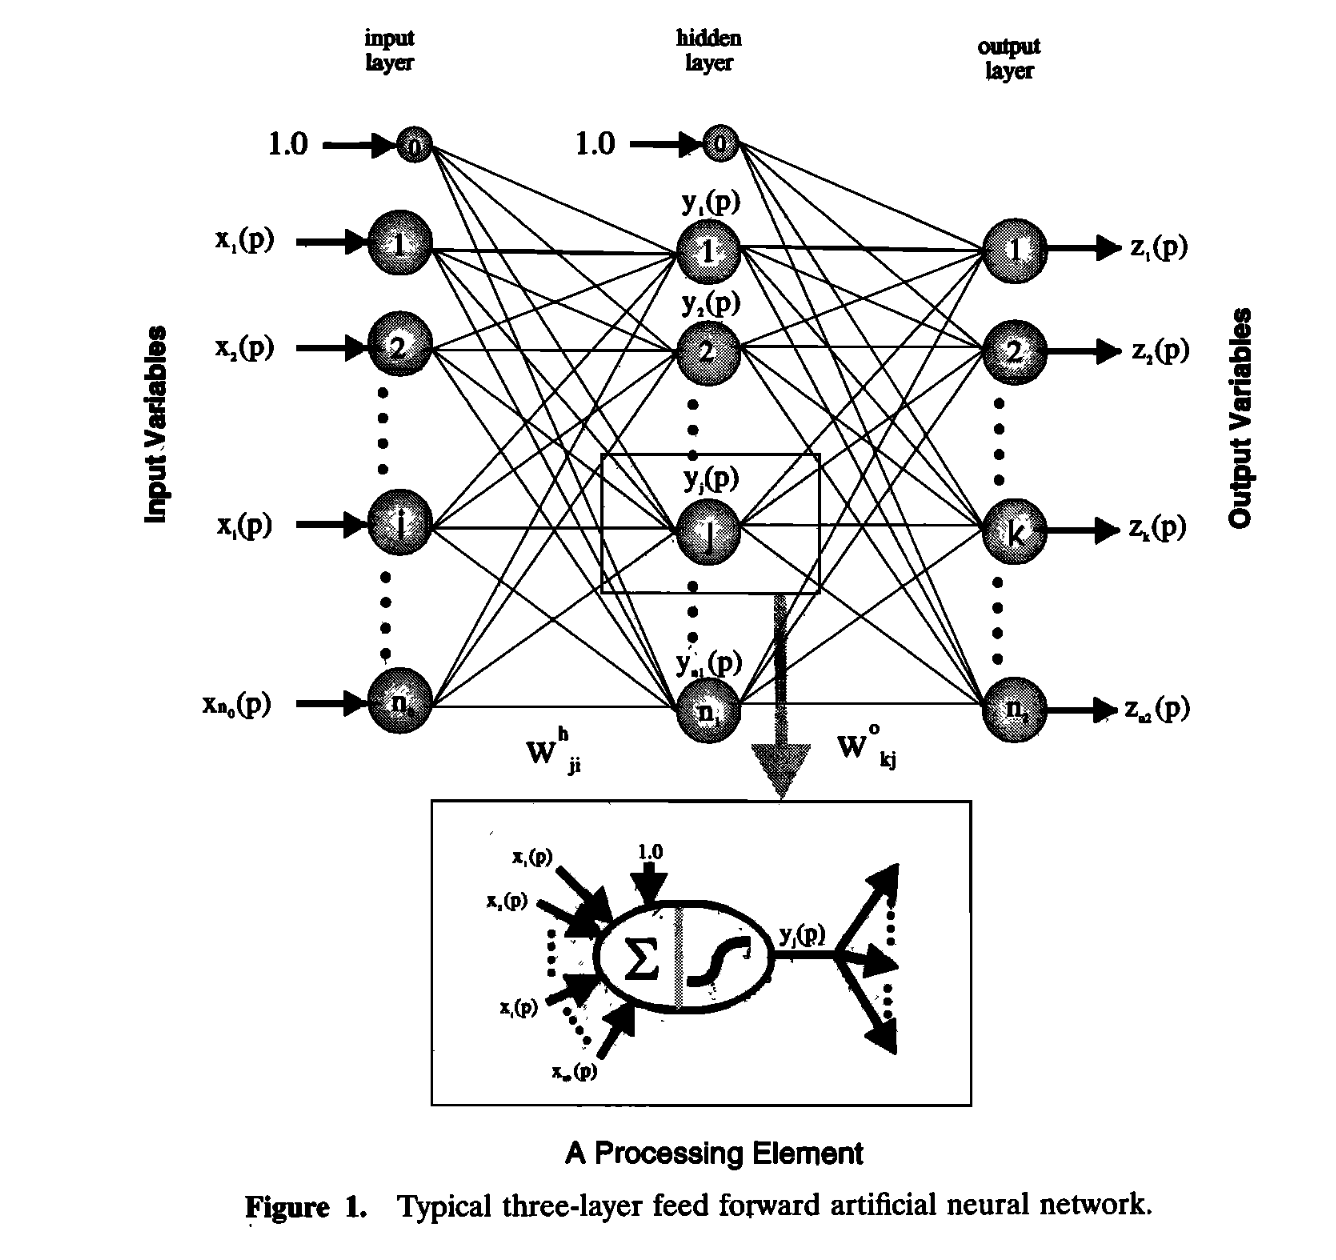

In [4]:
display(Image(filename = 'Fig 1_ Hsu et al_WRR 1995.png', width= 600, height= 300))

<span style="font-size: 24px;"> Splitting the data into training and testing: <span>

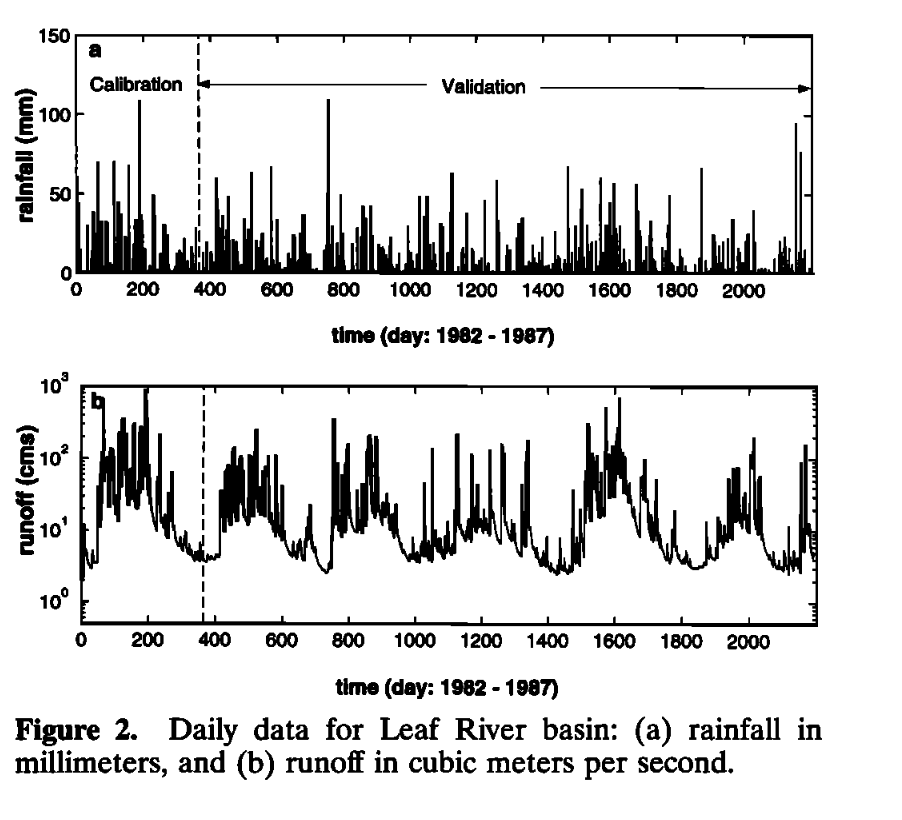

In [5]:
display(Image(filename = 'Fig 2_ Hsu et al_WRR 1995.png', width= 600, height= 300))

<span style="font-size: 24px;"> Model Selection: <span>

The inputs consist of: 
- Lagged Rainfall(t-$\tau$), $\tau = 1, 2, 3, 4, 5$
- Lagged Runoff(t-$\tau$), $\tau = 1, 2, 3, 4, 5$

In the table below:
- ANN(5, 4, 3, 1) means a multilayer perceptron with 5 lagged inputs for rainfall, 4 lagged inputs for runoff, hidden layer with 3 nodes, and 1 output.

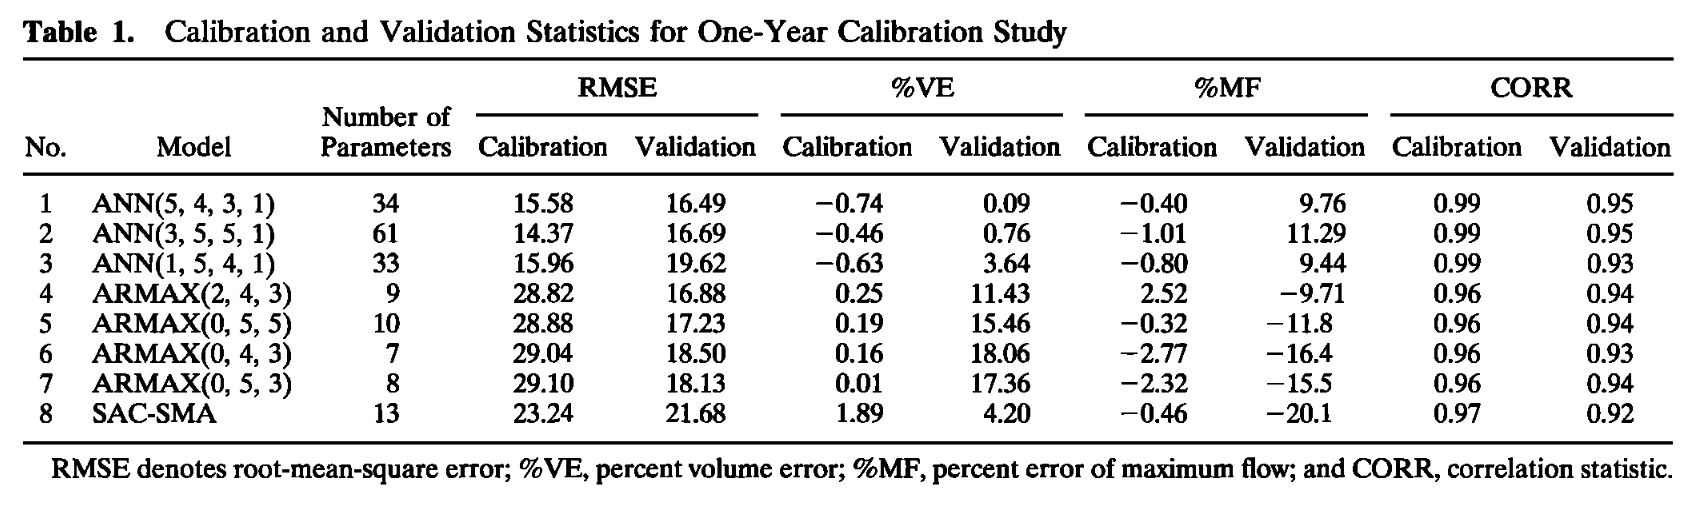

In [6]:
display(Image(filename = 'Table 1_ Hsu et al_WRR 1995.png', width= 800, height= 600))

<span style="font-size: 24px;"> Validation: <span>

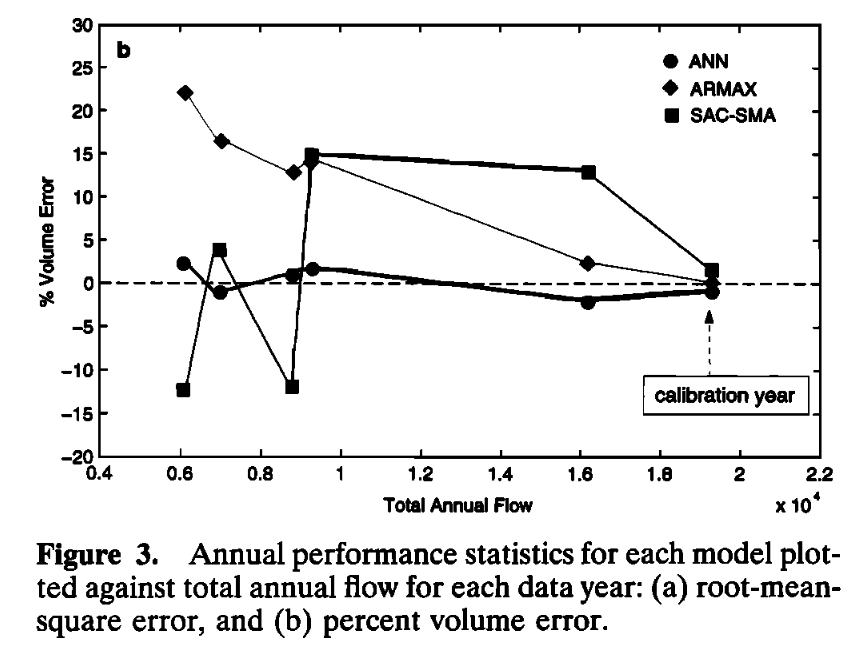

In [7]:
display(Image(filename = 'Fig 3b_ Hsu et al_WRR 1995.png', width= 800, height= 600))

## <center> Example: Building an MLP for Rainfall-Runoff Modelling </center>

Let's build an MLP model to replicate the Hsu et al (1995) study. Here, we're going to use data: 
- From a watershed in Maine (Fish River Watershed)
- For the time period 01/01/2016 to 12/31/2021 

Let's upload and plot the data:

In [8]:
fish_river = pd.read_csv('fish_river.csv')
print(fish_river.shape)
fish_river

(2192, 4)


,datetime,year,rainfall,runoff
0,2016-01-01,2016,0.000675,1720.0
1,2016-01-02,2016,0.144395,1680.0
2,2016-01-03,2016,2.918217,1640.0
3,2016-01-04,2016,0.000000,1580.0
4,2016-01-05,2016,0.000000,1520.0
...,...,...,...,...
2187,2021-12-27,2021,0.000000,989.0
2188,2021-12-28,2021,3.711825,972.0
2189,2021-12-29,2021,0.018728,947.0
2190,2021-12-30,2021,0.000000,928.0


### Processing the data:

Let's process the input data to have 4 variables (rainfall lagged by 1 and 2 times steps, and runoff lagged by 1 and 2 time steps):

In [9]:
data = fish_river.copy()
data['rainfall_tau_1'] = data['rainfall'].shift(1)
data['rainfall_tau_2'] = data['rainfall'].shift(2)

data['runoff_tau_1'] = data['runoff'].shift(1)
data['runoff_tau_2'] = data['runoff'].shift(2)

data = data.dropna()
data

,datetime,year,rainfall,runoff,rainfall_tau_1,rainfall_tau_2,runoff_tau_1,runoff_tau_2
2,2016-01-03,2016,2.918217,1640.0,0.144395,0.000675,1680.0,1720.0
3,2016-01-04,2016,0.000000,1580.0,2.918217,0.144395,1640.0,1680.0
4,2016-01-05,2016,0.000000,1520.0,0.000000,2.918217,1580.0,1640.0
5,2016-01-06,2016,0.000000,1450.0,0.000000,0.000000,1520.0,1580.0
6,2016-01-07,2016,0.000000,1390.0,0.000000,0.000000,1450.0,1520.0
...,...,...,...,...,...,...,...,...
2187,2021-12-27,2021,0.000000,989.0,0.000000,0.000000,1020.0,1070.0
2188,2021-12-28,2021,3.711825,972.0,0.000000,0.000000,989.0,1020.0
2189,2021-12-29,2021,0.018728,947.0,3.711825,0.000000,972.0,989.0
2190,2021-12-30,2021,0.000000,928.0,0.018728,3.711825,947.0,972.0


In [10]:
# Inputs (4 variables)
X = data[['rainfall_tau_1', 'rainfall_tau_2', 'runoff_tau_1', 'runoff_tau_2']]
X

,rainfall_tau_1,rainfall_tau_2,runoff_tau_1,runoff_tau_2
2,0.144395,0.000675,1680.0,1720.0
3,2.918217,0.144395,1640.0,1680.0
4,0.000000,2.918217,1580.0,1640.0
5,0.000000,0.000000,1520.0,1580.0
6,0.000000,0.000000,1450.0,1520.0
...,...,...,...,...
2187,0.000000,0.000000,1020.0,1070.0
2188,0.000000,0.000000,989.0,1020.0
2189,3.711825,0.000000,972.0,989.0
2190,0.018728,3.711825,947.0,972.0


In [11]:
# Ouputs (1 variable)
y = data[['runoff']]
y

,runoff
2,1640.0
3,1580.0
4,1520.0
5,1450.0
6,1390.0
...,...
2187,989.0
2188,972.0
2189,947.0
2190,928.0


### Building the model:

We're going to build a multilayer perceptron neural network for prediction, using Scikit-learn MLPRregressor. The documentation of the function is [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)

In [12]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [13]:
# Create an MLP (one hidden layer with 5 nodes) 
mlp = MLPRegressor(hidden_layer_sizes=(5,),
                   activation= 'relu',
                   solver= 'adam',
                   learning_rate= 'constant',
                   learning_rate_init= 0.001,
                   alpha= 0,
                   max_iter=1000, 
                   random_state=42)

In [14]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the model to the training data
mlp.fit(X_train, y_train)

MLPRegressor(alpha=0, hidden_layer_sizes=(5,), max_iter=1000, random_state=42)

### Evaluating the model:

In [15]:
pred = mlp.predict(X_test)
obs = y_test
obs = obs.values.reshape(-1,)

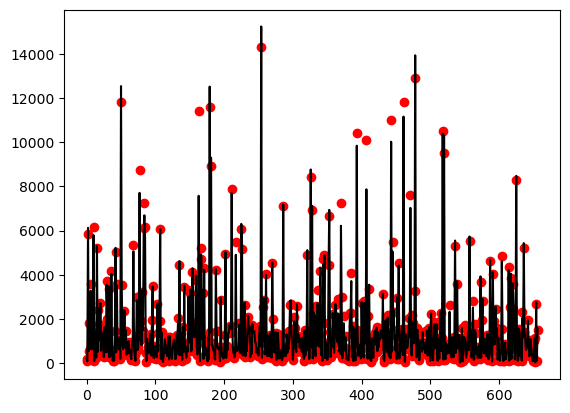

In [16]:
plt.plot(np.arange(len(obs)), obs, 'or', np.arange(len(pred)), pred, 'k')  

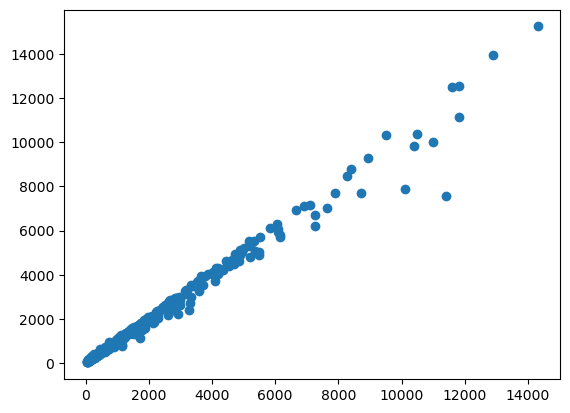

In [17]:
plt.scatter(obs, pred)

In [18]:
print('RMSE = ', np.round(np.sqrt(np.mean( (obs-pred)**2)))) 
print('Pearson correlation = ', np.round(np.corrcoef(obs, pred)[0,1], 3)) 
print('Relative Bias = ', np.round((np.mean(pred-obs)/np.mean(obs))*100), 3, ' %') 

RMSE =  232.0
Pearson correlation =  0.993
Relative Bias =  -0.0 3  %


### Extract Training Information:

Loss Curve

1000


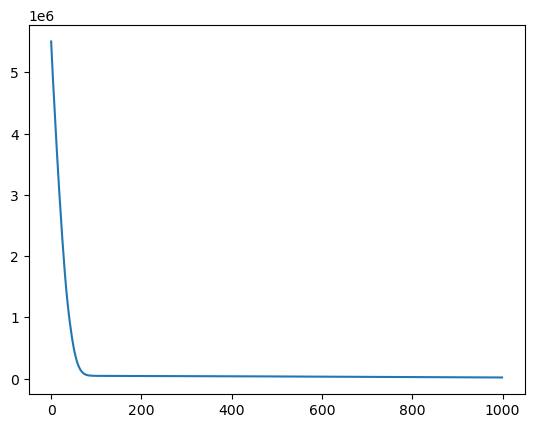

In [20]:
Loss_curve = mlp.loss_curve_
print(len(Loss_curve))
plt.plot(Loss_curve)

Number of samples for each iteration

## <center> Activation Functions </center>

In [21]:
def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y

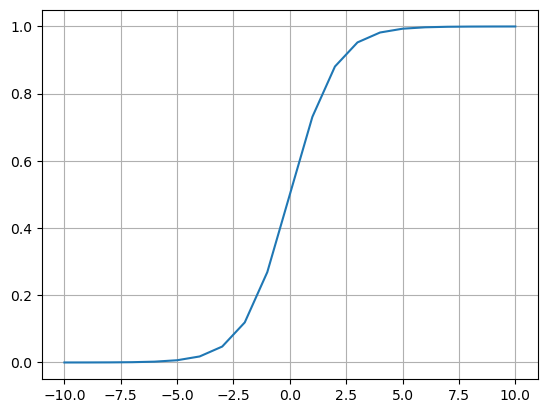

In [22]:
x = np.arange(-10,11)
y = sigmoid(x)
plt.plot(x, y)
plt.grid()
plt.savefig('sigmoid.jpeg', dpi= 600)

In [23]:
def ReLU(x):
    x = pd.Series(x)
    y = x.apply(lambda x: max(0, x))
    return y

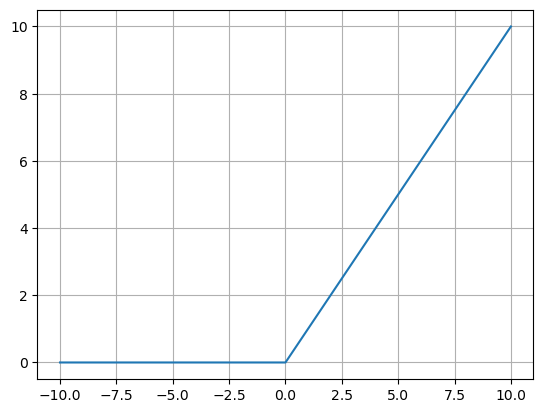

In [24]:
x = np.arange(-10,11)
y = ReLU(x)
plt.plot(x, y)
plt.grid()
plt.savefig('ReLU.jpeg', dpi= 600)

In [25]:
def softmax(x):
    y = np.exp(x) / np.sum(np.exp(x))
    return y

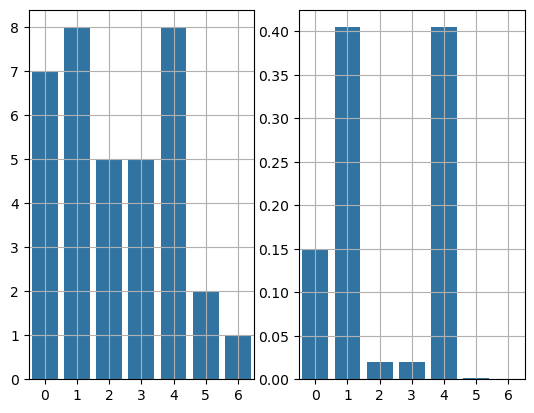

In [26]:
x = np.random.random_integers(1, 14, 7)
y = softmax(x)
plt.subplot(1,2,1)
sns.barplot(x)
plt.grid()

plt.subplot(1,2,2)
sns.barplot(y)
plt.grid()

plt.savefig('softmax.jpeg', dpi= 600)
plt.show()